In [4]:
import pandas as pd
import numpy as np
# Load the traffic data
df = pd.read_csv("C:/Users/mohan/OneDrive/Documents/TPA/data/traffic_data.csv",
                 parse_dates=["timestamp"])
df.head()

,id,timestamp,road_name,location_id,vehicle_count,avg_speed,day_of_week,is_weekend,is_holiday
0,1,2024-01-01 00:00:00,NH-16 Main,1,14,39.26,0,0,0
1,2,2024-01-01 00:00:00,City Ring Road,2,7,40.68,0,0,0
2,3,2024-01-01 00:00:00,IT Park Road,3,2,41.94,0,0,0
3,4,2024-01-01 01:00:00,NH-16 Main,1,18,46.01,0,0,0
4,5,2024-01-01 01:00:00,City Ring Road,2,3,41.10,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             2160 non-null   int64         
 1   timestamp      2160 non-null   datetime64[ns]
 2   road_name      2160 non-null   object        
 3   location_id    2160 non-null   int64         
 4   vehicle_count  2160 non-null   int64         
 5   avg_speed      2160 non-null   float64       
 6   day_of_week    2160 non-null   int64         
 7   is_weekend     2160 non-null   int64         
 8   is_holiday     2160 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 152.0+ KB


In [6]:
# Make a copy to avoid modifying original accidentally
data = df.copy()

# Extract hour from timestamp
data["hour"] = data["timestamp"].dt.hour

# day_of_week and is_weekend already exist, but we ensure types
data["day_of_week"] = data["day_of_week"].astype(int)
data["is_weekend"] = data["is_weekend"].astype(int)

In [7]:
# Sort by road and time to correctly compute rolling features
data = data.sort_values(["road_name", "timestamp"])

# For each road, compute rolling mean of last 3 hours' vehicle_count
data["rolling_mean_3h"] = (
    data
    .groupby("road_name")["vehicle_count"]
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

data[["timestamp", "road_name", "vehicle_count", "rolling_mean_3h"]].head(10)


,timestamp,road_name,vehicle_count,rolling_mean_3h
1,2024-01-01 00:00:00,City Ring Road,7,7.000000
4,2024-01-01 01:00:00,City Ring Road,3,5.000000
7,2024-01-01 02:00:00,City Ring Road,9,6.333333
10,2024-01-01 03:00:00,City Ring Road,9,7.000000
13,2024-01-01 04:00:00,City Ring Road,0,6.000000
16,2024-01-01 05:00:00,City Ring Road,13,7.333333
19,2024-01-01 06:00:00,City Ring Road,21,11.333333
22,2024-01-01 07:00:00,City Ring Road,57,30.333333
25,2024-01-01 08:00:00,City Ring Road,77,51.666667
28,2024-01-01 09:00:00,City Ring Road,79,71.000000


In [8]:
# Features we will use
feature_cols = [
    "hour",
    "day_of_week",
    "is_weekend",
    "location_id",
    "rolling_mean_3h"
]

X = data[feature_cols]
y = data["vehicle_count"]

X.head(), y.head()


(    hour  day_of_week  is_weekend  location_id  rolling_mean_3h
 1      0            0           0            2         7.000000
 4      1            0           0            2         5.000000
 7      2            0           0            2         6.333333
 10     3            0           0            2         7.000000
 13     4            0           0            2         6.000000,
 1     7
 4     3
 7     9
 10    9
 13    0
 Name: vehicle_count, dtype: int64)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((1728, 5), (432, 5))

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Create the model
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

# Train (fit) the model
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE (Mean Absolute Error): {mae:.2f} vehicles")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} vehicles")


MAE (Mean Absolute Error): 6.06 vehicles
RMSE (Root Mean Squared Error): 7.66 vehicles


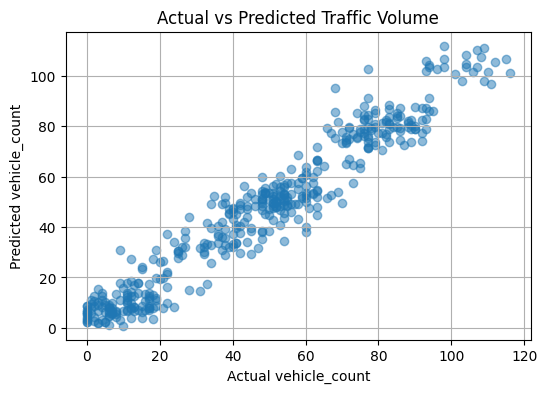

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual vehicle_count")
plt.ylabel("Predicted vehicle_count")
plt.title("Actual vs Predicted Traffic Volume")
plt.grid(True)
plt.show()


In [16]:
import joblib
import os

# Make sure models folder exists
os.makedirs("C:/Users/mohan/OneDrive/Documents/TPA/backend/models", exist_ok=True)

model_artifact = {
    "model": model,
    "feature_cols": feature_cols
}

model_path = "C:/Users/mohan/OneDrive/Documents/TPA/backend/models/traffic_model.pkl"
joblib.dump(model_artifact, model_path)

print(f"Model saved to: {model_path}")


Model saved to: C:/Users/mohan/OneDrive/Documents/TPA/backend/models/traffic_model.pkl
